Import libraries

In [247]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate, Dropout, TextVectorization, LSTM, BatchNormalization, Activation, Lambda, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import backend as K
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Load dataset

In [248]:
pd.set_option('display.max_columns', None)
#df = pd.read_csv('Merged_df.csv', index_col=0, low_memory=False)
df = pd.read_csv("/kaggle/input/merged-df/Merged_df.csv", index_col=0, low_memory=False)

Drop unnecessary columns [Not utilized in analysis]

In [249]:
df1 = df.drop(['MovieID', 'Timestamp', 'Title', 'Genres', 'ZipCode', 'Movie_Title',
               'status', 'backdrop_path', 'homepage', 'imdb_id', 'poster_path', 'production_companies',  "overview", "tagline",
               'production_countries', 'title_year', 'year', 'original_language', "release_date", "original_title", "spoken_languages", "revenue", "budget"], axis=1)

Coerce Numerical Features which have values as 0 to NA 

In [250]:
# Define Numerical Features
numerical_features = ['vote_average', 'vote_count', 'runtime', 'popularity'] # Did not consider revenue and budget as there are lots of values which are 0

# Coerce '0' values to NA
df1[numerical_features] = df1[numerical_features].replace(0, pd.NA)

Drop rows with NA values

In [251]:
df1.dropna(inplace=True)

Convert 'adult' column to integers

In [252]:
# Convert 'adult' column to integers (1 for True, 0 for False)
df1['adult'] = df1['adult'].astype(int)

Convert movieids to integers

In [253]:
df1['id'] = df1['id'].astype(int)

Handle outliers in numerical columns

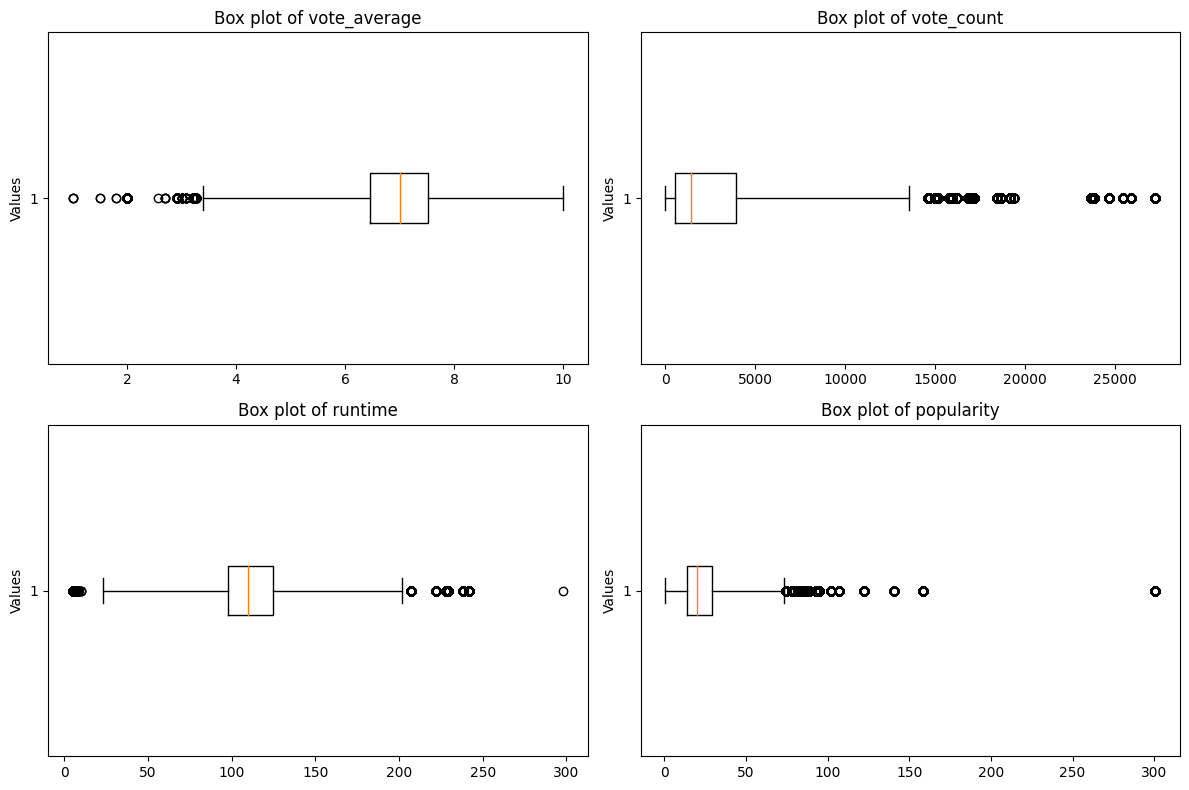

In [254]:
# Create a box plot for each column
plt.figure(figsize=(12, 8))  # Set the figure size for better readability

for i, column in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)  # This creates a 2x2 grid of subplots
    
    plt.boxplot(df1[column], whis=3, vert = False)
    #sns.boxplot(y=df_combined[column])
    plt.title(f'Box plot of {column}')  # Title for each subplot
    plt.ylabel('Values')  # Set the y-axis label

plt.tight_layout()
plt.show()

In [255]:
# Don't need to touch vote_average or vote_count

# Runtime can significantly skew results
runtime_q1 = df1["runtime"].quantile(0.25)
runtime_q3 = df1["runtime"].quantile(0.75)
runtime_iqr = runtime_q3 - runtime_q1

runtime_lowerbound = runtime_q1 - 3*runtime_iqr
runtime_upperbound = runtime_q3 + 3*runtime_iqr

# Remove Outliers if runtime falls outside 3 * IQR 
df1 = df1[(df1["runtime"] >= runtime_lowerbound) & (df1["runtime"] <= runtime_upperbound)]

# Capping outliers for popularity scores to 100
df1['popularity'] = df1['popularity'].apply(lambda x: 100 if x > 100 else x)

Encode Catgorical features & Scale Numerical Variables

In [256]:
# Define categorical and numerical features
categorical_features = ['Gender', 'Occupation', 'Age']

# One-Hot Encoding for categorical variables
one_hot_encoder = OneHotEncoder(sparse=False)  # Using sparse=False to get a dense array
encoded_features = one_hot_encoder.fit_transform(df1[categorical_features])

# Normalize Numerical Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df1[numerical_features])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Convert Genres into Multiple Binary Columns

In [257]:
# Since genres are separated by commas in dataset
df1['genres'] = df1['genres'].apply(lambda x: x.split(', '))

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df1['genres'])

Before concatenating, Drop all original variables which have been transformed

In [258]:
df1.drop(categorical_features, axis=1, inplace=True)
df1.drop(numerical_features, axis=1, inplace=True)
df1.drop("genres", axis=1, inplace=True)

Combine all processed features back into one dataframe

In [259]:
# Convert encoded categorical features, scaled numerical features, and multiple genere features back to DataFrame 
encoded_cats = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=df1.index)
scaled_nums = pd.DataFrame(scaled_features, columns=numerical_features, index=df1.index)
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df1.index)

# Combine all features
df_combined = pd.concat([df1, encoded_cats, scaled_nums,genres_df], axis=1)

Split into train and test dataset

In [260]:
df_train_combined, df_test_combined = train_test_split(df_combined, test_size=0.2, random_state=42)

Create User embeddings

In [261]:
num_users = df_train_combined['UserID'].max() + 1  # Add 1 to handle index error as python indexes from 0, then index 0 will be unused/reserved

# UsedID embeddings
user_id_input = Input(shape=(1,), name='user_id_input')  # Entry point for User IDs  --> Each input is a single value

# Aim to capture 10 latent characteristics of each user (10 dimensions)
# input_dim is the total number of unique users
user_embedding = Embedding(input_dim=num_users, output_dim=10, name='user_embedding')(user_id_input) # Transforms each userID into a dense vector of size 10
user_flatten = Flatten(name='user_flatten')(user_embedding) # Flatten to a 1D tensor

User demographics

In [262]:
demographic_features = ['Gender_F', 'Gender_M', 'Occupation_0', 'Occupation_1', 'Occupation_2',
                        'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
                        'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
                        'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
                        'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
                        'Occupation_19', 'Occupation_20', 'Age_1', 'Age_18', 'Age_25', 'Age_35',
                        'Age_45', 'Age_50', 'Age_56']

# User demographics input
user_demographics_input = Input(shape=(len(demographic_features),), name='user_demographics_input')

Create Movie Embeddings

In [263]:
num_movies = df_train_combined['id'].max() + 1 # Add 1 to handle index error as python indexes from 0, then index 0 will be unused/reserved

# MovieID embeddings
movie_id_input = Input(shape=(1,), name='movie_id_input')  # Entry point for Movie IDs  --> Each input is a single value

# Aim to capture 50 latent characteristics of each movie due to large number of unique movies (50 dimensions)
# input_dim is the total number of unique movies
movie_embedding = Embedding(input_dim=num_movies, output_dim=50, name='movie_embedding')(movie_id_input)
movie_flatten = Flatten(name='movie_flatten')(movie_embedding)

Movie Features

In [264]:
movie_features_columns = ['vote_average', 'vote_count', 'runtime', 'popularity',
                          'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
                          'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
                          'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'adult']

num_movie_features = len(movie_features_columns)

movie_input = Input(shape=(num_movie_features,), name='movie_input')

Combine model inputs

In [265]:
# Combine user and movie inputs
combined_inputs = concatenate([user_flatten, user_demographics_input, movie_flatten, movie_input])

Assemble Complete Model

In [266]:
# Add fully connected layers
fc1 = Dense(256, activation='relu')(combined_inputs) 
dropout1 = Dropout(0.25)(fc1)

fc2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.25)(fc2)

fc3 = Dense(64, activation='relu')(dropout2)
output = Dense(1, activation='sigmoid')(fc3) 
output =Lambda(lambda x: x * 5)(output)

# Finalizing the model
model = Model(inputs=[user_id_input, user_demographics_input, movie_id_input, movie_input], outputs=output)
lr_schedule = ExponentialDecay(initial_learning_rate=0.004, decay_steps=10000, decay_rate=0.9) # Learning Rate Scheduling

# Compiling the model
model.compile(optimizer=Adam(lr_schedule), loss='mean_squared_error')

# Model summary to check the architecture
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 10)     │     60,410 │ user_id_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │ 53,868,050 │ movie_id_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 10)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_demographics_… │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_flatten       │ (None, 50)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 114)       │          0 │ user_flatten[0][… │
│ (Concatenate)       │                   │            │ user_demographic… │
│                     │                   │            │ movie_flatten[0]… │
│                     │                   │            │ movie_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     29,440 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     32,896 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,999,117 (205.99 MB)

 Trainable params: 53,999,117 (205.99 MB)

 Non-trainable params: 0 (0.00 B)

Preparing Inputs for training

In [267]:
# Extract ratings (Y-values)
ratings_train = df_train_combined['Rating'].values
ratings_test = df_test_combined['Rating'].values

# Prepare inputs for training
user_ids_train = df_train_combined['UserID'].values
movie_ids_train = df_train_combined['id'].values
user_demographics_train = df_train_combined[demographic_features].values
movie_features_train = df_train_combined[movie_features_columns].values

# Prepare inputs for testing (evaluation)
user_ids_test = df_test_combined['UserID'].values
movie_ids_test = df_test_combined['id'].values
user_demographics_test = df_test_combined[demographic_features].values
movie_features_test = df_test_combined[movie_features_columns].values

Train the Model

In [268]:
history = model.fit([user_ids_train, user_demographics_train, movie_ids_train, movie_features_train], ratings_train,
                    validation_data=([user_ids_test, user_demographics_test, movie_ids_test, movie_features_test], ratings_test),
                    epochs=5,
                    batch_size=128)

Epoch 1/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 112s 17ms/step - loss: 0.8984 - val_loss: 0.8066
Epoch 2/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - loss: 0.7808 - val_loss: 0.7662
Epoch 3/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - loss: 0.7441 - val_loss: 0.7684
Epoch 4/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - loss: 0.7209 - val_loss: 0.7523
Epoch 5/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - loss: 0.7048 - val_loss: 0.7488


Process TMDB Dataset

In [281]:
# Load Dataset
tmdb_df = pd.read_csv("/kaggle/input/tmdb-movies/TMDB_movie_dataset_v11.csv", index_col=0, low_memory=False)

# Cleaning up the release date column to coerce problematic values to NaT, and ensure dates are in proper format
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], errors='coerce')

# Creating new "year" (string) column and extracting year from the "release_date" field
tmdb_df['year'] = tmdb_df['release_date'].dt.year.astype('Int64').astype(str).replace('<NA>', '')

# Drop unnecessary columns not used in analysis
tmdb_df1 = tmdb_df.drop(['status', 'backdrop_path', 'homepage', 'imdb_id', 'poster_path', 'production_companies','production_countries', 'release_date', 
                         'original_language', "original_title", "spoken_languages", "overview", "tagline", "revenue", "budget"], axis=1)

Check and handle outliers for numerical features

In [282]:
# Coerce '0' values to NA for numerical features
tmdb_df1[numerical_features] = tmdb_df1[numerical_features].replace(0, pd.NA)

# Drop rows with 0 for numerical features (as it will skew/bias the results if included)
tmdb_df1 = tmdb_df1.dropna(subset=numerical_features)

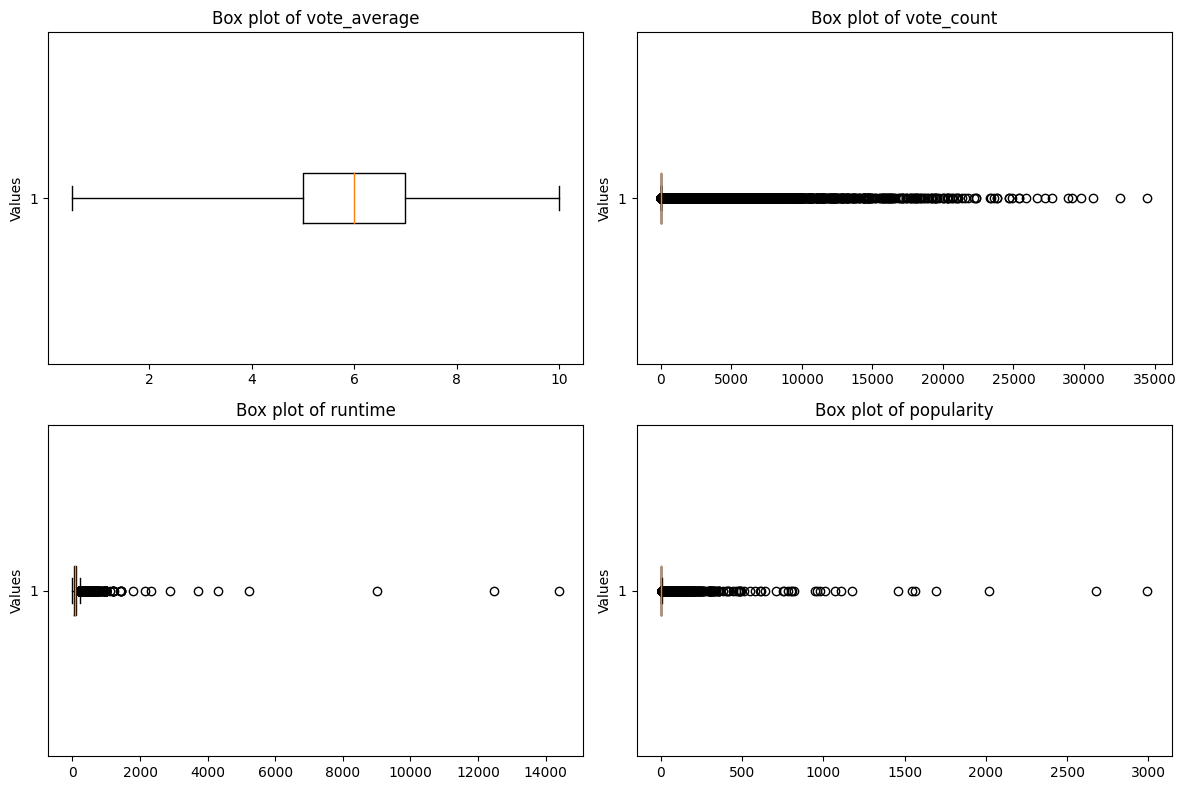

In [283]:
# Create a box plot for each numerical feature
plt.figure(figsize=(12, 8))  # Set the figure size for better readability

for i, column in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)  # This creates a 2x2 grid of subplots
    
    plt.boxplot(tmdb_df1[column], whis=3, vert = False)
    plt.title(f'Box plot of {column}')  # Title for each subplot
    plt.ylabel('Values')  # Set the y-axis label

plt.tight_layout()
plt.show()

In [285]:
# Don't need to touch vote_average or vote_count

# Runtime can significantly skew results
runtime_q1_tmdb = tmdb_df1["runtime"].quantile(0.25)
runtime_q3_tmdb = tmdb_df1["runtime"].quantile(0.75)
runtime_iqr_tmdb = runtime_q3_tmdb - runtime_q1_tmdb

runtime_lowerbound_tmdb = runtime_q1_tmdb - 3*runtime_iqr_tmdb
runtime_upperbound_tmdb = runtime_q3_tmdb + 3*runtime_iqr_tmdb

# Remove Outliers if runtime falls outside 3 * IQR 
tmdb_df1 = tmdb_df1[(tmdb_df1["runtime"] >= runtime_lowerbound_tmdb) & (tmdb_df1["runtime"] <= runtime_upperbound_tmdb)]

# Capping outliers for popularity scores to 100
tmdb_df1.loc[:,'popularity'] = tmdb_df1['popularity'].apply(lambda x: 100 if x > 100 else x)

Convert "Adult" column to binary

In [287]:
# Convert 'adult' column to integers (1 for True, 0 for False)
tmdb_df1['adult'] = tmdb_df1['adult'].astype(int)

Scaling and encoding genres

In [288]:
# Scale numerical features
scaled_features1 = scaler.transform(tmdb_df1[numerical_features])
scaled_nums1 = pd.DataFrame(scaled_features1, columns=numerical_features, index=tmdb_df1.index)

# Have multiple genres and one hot encode it
tmdb_df1.loc[:,'genres'] = tmdb_df1['genres'].astype(str)
tmdb_df1.loc[:,'genres'] = tmdb_df1['genres'].apply(lambda x: x.split(', ') if x != 'nan' else [])
genres_encoded1 = mlb.transform(tmdb_df1['genres'])
genres_df1 = pd.DataFrame(genres_encoded1, columns=mlb.classes_, index=tmdb_df1.index)

# Drop Original features
tmdb_df1 = tmdb_df1.drop(numerical_features, axis=1)
tmdb_df1 = tmdb_df1.drop("genres", axis=1)

# Concat all new features
tmdb_df2 = pd.concat([tmdb_df1, scaled_nums1, genres_df1], axis=1)

Predict Ratings with titles for a particular user

In [290]:
def predict_ratings_for_user_with_titles(user_id, data2, num_recommendations=5, model = model, data1 = df_combined):
    
    # Extract user IDs
    user_id_input = np.array([user_id] * len(data2))
    
    # Extract dataset for this particular user and just keep first row as features will be constant
    user_df = data1[data1['UserID'] == user_id][:1]

    # Extract users demographic features and repeat for the length of unseen movies
    user_demographics_pred = np.repeat(user_df[demographic_features].values, len(data2), axis=0)
    
    # Extract Movie IDs
    movie_id_input = data2.index.values
    
    # Extract Movie features input
    movie_features_input = data2[movie_features_columns].values
    
    # Predict Ratings for unseen movies
    predicted_ratings = model.predict([user_id_input, user_demographics_pred, movie_id_input, movie_features_input])
    
    new_df = data2.copy()
    
    new_df["predicted_ratings"] = predicted_ratings    
    
    new_df.sort_values(by='predicted_ratings', ascending=False, inplace = True)
    
    final_movies_df = new_df[["title", "year", "predicted_ratings"]].head(num_recommendations)

    return final_movies_df

Check predictions for User 200

In [291]:
predict_ratings_for_user_with_titles(200,data2 = tmdb_df2, num_recommendations = 10)

9344/9344 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


,title,year,predicted_ratings
id,,,
292112,Family Reunion,1981,4.801293
740967,It's a Long Way to October,,4.800671
238090,Rage of Angels: The Story Continues,1986,4.794733
1026058,Common Ground,1990,4.788989
178548,Donne sbagliate,2007,4.787824
437566,Hearts of Gold,2003,4.787399
676287,Notti e nebbie,1984,4.781588
75049,American Tragedy,2000,4.781430
915938,The Peacock Spring,1996,4.780948


Check predictions for User 3000

In [292]:
predict_ratings_for_user_with_titles(3000, data2 = tmdb_df2, num_recommendations = 10)

9344/9344 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


,title,year,predicted_ratings
id,,,
109475,Ironclads,1991,4.804048
842360,Kamala Harris To Be The First,2020,4.797912
32337,Man Hunters: Sex Trips for Girls,2008,4.796240
850412,A Tribute to Club Penguin,2020,4.794533
252892,Superpride,2008,4.794444
297681,Section 60: Arlington National Cemetery,2008,4.793829
1008396,Escape from Irpin,2022,4.793546
984325,The Making of Poltergeist,1982,4.793444
608715,Reimagining A Buffalo Landmark,2019,4.793102


In [293]:
# Function to get users input for new users to predict based on their demographic features
def get_user_input():
    print("Please enter your demographic information:")
    
    # Display gender choices
    print("Gender is denoted by a 'M' for male and 'F' for female.")
    gender = input("Gender (F/M): ").strip().upper()
    
    # Display age choices
    print("\nAge is chosen from the following ranges:")
    print("  1: 'Under 18'")
    print(" 18: '18-24'")
    print(" 25: '25-34'")
    print(" 35: '35-44'")
    print(" 45: '45-49'")
    print(" 50: '50-55'")
    print(" 56: '56+'")
    age = int(input("Enter the number corresponding to your age group: "))
    
    # Display occupation choices
    print("\nOccupation is chosen from the following choices:")
    print("  0: 'other' or not specified")
    print("  1: 'academic/educator'")
    print("  2: 'artist'")
    print("  3: 'clerical/admin'")
    print("  4: 'college/grad student'")
    print("  5: 'customer service'")
    print("  6: 'doctor/health care'")
    print("  7: 'executive/managerial'")
    print("  8: 'farmer'")
    print("  9: 'homemaker'")
    print(" 10: 'K-12 student'")
    print(" 11: 'lawyer'")
    print(" 12: 'programmer'")
    print(" 13: 'retired'")
    print(" 14: 'sales/marketing'")
    print(" 15: 'scientist'")
    print(" 16: 'self-employed'")
    print(" 17: 'technician/engineer'")
    print(" 18: 'tradesman/craftsman'")
    print(" 19: 'unemployed'")
    print(" 20: 'writer'")
    occupation = int(input("Enter the number corresponding to your occupation: "))
    
    # Convert inputs to model-compatible format (one-hot encoding)
    user_data = np.zeros((1, 30))  # 30 features as per your model
    if gender == 'F':
        user_data[0, 0] = 1  # Gender_F
    else:
        user_data[0, 1] = 1  # Gender_M

    # Set occupation (assuming 0-20 are correctly input)
    user_data[0, 2 + occupation] = 1

    # Set age
    age_indices = {1: 23, 18: 24, 25: 25, 35: 26, 45: 27, 50: 28, 56: 29}
    user_data[0, age_indices[age]] = 1

    return user_data


In [294]:
def recommend_movies_for_new_user(data2, num_recommendations=5, model = model, data1 = df_combined):
    
    # initialize random user id = 10000 (does not exist in data)
    user_id_input = np.array([10001] * len(data2))
    
    # Get user demographic features
    user_data = get_user_input()
    user_demographics_pred = np.repeat(user_data, len(data2), axis=0)
    
    # Extract Movie IDs
    movie_id_input = data2.index.values
    # Extract Movie features input
    movie_features_input = data2[movie_features_columns].values
    
    # Predict Ratings for unseen movies
    predicted_ratings = model.predict([user_id_input, user_demographics_pred, movie_id_input, movie_features_input])
    
    data2["predicted_ratings"] = predicted_ratings    
    
    data2.sort_values(by='predicted_ratings', ascending=False, inplace = True)
    
    final_movies_df = data2[["title", "year", "predicted_ratings"]].head(num_recommendations)

    return final_movies_df

Test for new user: M, 18, 4

In [295]:
recommend_movies_for_new_user(data2 = tmdb_df2)

Please enter your demographic information:
Gender is denoted by a 'M' for male and 'F' for female.


Gender (F/M):  M



Age is chosen from the following ranges:
  1: 'Under 18'
 18: '18-24'
 25: '25-34'
 35: '35-44'
 45: '45-49'
 50: '50-55'
 56: '56+'


Enter the number corresponding to your age group:  18



Occupation is chosen from the following choices:
  0: 'other' or not specified
  1: 'academic/educator'
  2: 'artist'
  3: 'clerical/admin'
  4: 'college/grad student'
  5: 'customer service'
  6: 'doctor/health care'
  7: 'executive/managerial'
  8: 'farmer'
  9: 'homemaker'
 10: 'K-12 student'
 11: 'lawyer'
 12: 'programmer'
 13: 'retired'
 14: 'sales/marketing'
 15: 'scientist'
 16: 'self-employed'
 17: 'technician/engineer'
 18: 'tradesman/craftsman'
 19: 'unemployed'
 20: 'writer'


Enter the number corresponding to your occupation:  4


9344/9344 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


,title,year,predicted_ratings
id,,,
32337,Man Hunters: Sex Trips for Girls,2008,4.858462
842360,Kamala Harris To Be The First,2020,4.857840
297681,Section 60: Arlington National Cemetery,2008,4.857827
984325,The Making of Poltergeist,1982,4.857344
608715,Reimagining A Buffalo Landmark,2019,4.857281


Test for new user: F, 50, 2

In [296]:
recommend_movies_for_new_user(data2 = tmdb_df2)

Please enter your demographic information:
Gender is denoted by a 'M' for male and 'F' for female.


Gender (F/M):  F



Age is chosen from the following ranges:
  1: 'Under 18'
 18: '18-24'
 25: '25-34'
 35: '35-44'
 45: '45-49'
 50: '50-55'
 56: '56+'


Enter the number corresponding to your age group:  50



Occupation is chosen from the following choices:
  0: 'other' or not specified
  1: 'academic/educator'
  2: 'artist'
  3: 'clerical/admin'
  4: 'college/grad student'
  5: 'customer service'
  6: 'doctor/health care'
  7: 'executive/managerial'
  8: 'farmer'
  9: 'homemaker'
 10: 'K-12 student'
 11: 'lawyer'
 12: 'programmer'
 13: 'retired'
 14: 'sales/marketing'
 15: 'scientist'
 16: 'self-employed'
 17: 'technician/engineer'
 18: 'tradesman/craftsman'
 19: 'unemployed'
 20: 'writer'


Enter the number corresponding to your occupation:  2


9344/9344 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


,title,year,predicted_ratings
id,,,
718578,Heaven and Earth: Dawn Episode,1990,4.832956
729058,The Journey of the African-American Athlete,1996,4.832740
686694,The Years of the Sweet Sin,2018,4.830334
109475,Ironclads,1991,4.830314
775839,Godzilla's Leading Ladies,2020,4.828850
